# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Aura Melina Gutierrez Jimenez

**Professor**: Pablo Camarillo Ramirez

# Introduction

**Problemática a Resolver: Optimización del Tráfico Urbano en Tiempo Real**

La creciente congestión vehicular en grandes ciudades es un desafío crítico que provoca pérdidas económicas, desgaste de la infraestructura, aumento de la contaminación ambiental y una menor calidad de vida. El objetivo de este trabajo es integrar, procesar y analizar datos de tráfico urbano masivos y heterogéneos y generar insights accionables que permitan optimizar el flujo de tráfico en tiempo real.

# Dataset

**Origen del Dataset**

Seleccione un conjunto de datos público que refleja mediciones reales de infraestructura de tráfico urbano.

Nombre del Dataset: Chicago Average Daily Traffic Counts

Fuente: Kaggle Public Repository

URL: https://www.kaggle.com/datasets/chicago/chicago-average-daily-traffic-counts

Archivo Principal: average-daily-traffic-counts.csv


**Modelo de datos**

El dataset de origen es una tabla simple donde cada fila es una medición discreta de volumen de tráfico en una ubicación y momento específicos. Esta estructura tabular se mantiene a lo largo de la transformación, lo que facilita el uso de un modelo relacional para el análisis y la persistencia.


**Esquema de datos**
Aunque el archivo CSV contiene 15 columnas iniciales, el pipeline optimiza el esquema para centrarse únicamente en las 6 columnas esenciales para el análisis de congestión. 

- ID: IntegerType (Identificador único del punto de conteo de tráfico)

- STREET_NAME: StringType (Nombre de la calle donde se tomó la medición)

- DATE_OF_COUNT: StringType (Fecha y hora exacta de la medición (formato ISO 8601))

- TOTAL_VEHICLE_VOLUME: IntegerType (Volumen total de vehículos contados en ese punto)

- LATITUDE: DoubleType (Coordenada geográfica de latitud del punto de conteo)

- LONGITUDE: DoubleType (Coordenada geográfica de longitud del punto de conteo)

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Final project Batch Processing") \
    .master("spark://spark-master:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

25/10/26 18:53:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from auragutierrez.spark_utils import SparkUtils
from pyspark.sql.functions import col, to_timestamp


traffic_schema_columns = [
    ("ID", "int"),
    ("LOCATION_ADDRESS", "string"),
    ("STREET_NAME", "string"),
    ("DATE_OF_COUNT", "string"),
    ("TOTAL_VEHICLE_VOLUME", "int"),
    ("DIRECTIONAL_VOLUME", "string"),
    ("LATITUDE", "double"),
    ("LONGITUDE", "double"),
    ("LOCATION_RAW", "string"),
    ("BOUNDARIES_ZIP_CODES", "int"),
    ("COMMUNITY_AREAS", "int"),
    ("ZIP_CODES", "int"),
    ("CENSUS_TRACTS", "int"),
    ("WARDS", "int"),
    ("HISTORICAL_WARDS_2003_2015", "int")
]

traffic_schema = SparkUtils.generate_schema(traffic_schema_columns)

base_path = "/opt/spark/work-dir/data/"
df_traffic = spark.read \
                .option("header", "true") \
                .schema(traffic_schema) \
                .csv(base_path + "/Traffic/")

In [3]:
df_traffic = df_traffic.select(
    "ID",
    "STREET_NAME",
    "DATE_OF_COUNT",
    "TOTAL_VEHICLE_VOLUME",
    "LATITUDE",
    "LONGITUDE")

# Transformations and Actions

In [4]:
from pyspark.sql.functions import col, to_timestamp, lit, upper, trim, hour, dayofweek, avg, when
from pyspark.sql.window import Window

df_transformed = df_traffic.withColumn(
    "COUNT_TIMESTAMP",
    to_timestamp(col("DATE_OF_COUNT"), "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'")
).drop("DATE_OF_COUNT")

df_clean = df_transformed.filter(
    (col("TOTAL_VEHICLE_VOLUME").isNotNull()) & 
    (col("TOTAL_VEHICLE_VOLUME") > 0) &
    (col("LATITUDE").isNotNull()) &
    (col("COUNT_TIMESTAMP").isNotNull()))

df_features = df_clean.withColumn(
    "STREET_NAME_CLEAN", 
    upper(trim(col("STREET_NAME"))) 
).withColumn(
    "HOUR_OF_DAY", 
    hour(col("COUNT_TIMESTAMP"))
).withColumn(
    "DAY_TYPE",
    when(dayofweek(col("COUNT_TIMESTAMP")).isin(1, 7), lit("Weekend"))
    .otherwise(lit("WeekDay")))

In [5]:
window_spec_street = Window.partitionBy("STREET_NAME_CLEAN")

df_base_traffic = df_features.withColumn(
    "AVG_HISTORICAL_VOLUME",
    avg(col("TOTAL_VEHICLE_VOLUME")).over(window_spec_street))

df_enriched = df_base_traffic.withColumn(
    "TRAFFIC_DENSITY_INDEX",
    col("TOTAL_VEHICLE_VOLUME") / col("AVG_HISTORICAL_VOLUME")
).withColumn(
    "CONGESTION_LEVEL",
    when(col("TRAFFIC_DENSITY_INDEX") >= 1.5, lit("High Congestion"))
    .when((col("TRAFFIC_DENSITY_INDEX") >= 1.0) & (col("TRAFFIC_DENSITY_INDEX") < 1.5), lit("Above Average"))
    .otherwise(lit("Normal/Low")))

In [6]:
df_traffic_insights = df_enriched.groupBy(
    "STREET_NAME_CLEAN",
    "LATITUDE",
    "LONGITUDE",
    "DAY_TYPE",
    "HOUR_OF_DAY"
).agg(
    avg(col("AVG_HISTORICAL_VOLUME")).alias("AVG_STREET_VOLUME"), # Volumen promedio de la calle
    avg(col("TOTAL_VEHICLE_VOLUME")).alias("AVG_HOURLY_VOLUME_FOR_TYPE"), # Volumen promedio para esa hora y día
    avg(col("TRAFFIC_DENSITY_INDEX")).alias("AVG_CONGESTION_INDEX_BY_HOUR")) # Métrica clave

# Persistence Data

**Justificación de la Selección de la Base de Datos: PostgreSQL**

La selección de PostgreSQL (SQL) es la óptima y se justifica por el modelo de datos Relacional generado y las necesidades operativas del proyecto.
Justificación Clave: 
- El producto final de la pipeline es una tabla plana y altamente estructurada (Calle, Hora, Índice de Congestión). PostgreSQL está optimizado para la integridad y el manejo eficiente de este esquema fijo.

- Un sistema de optimización requiere búsquedas rápidas. PostgreSQL permite crear índices compuestos sobre las claves de consulta (STREET_NAME_CLEAN, HOUR_OF_DAY), asegurando que las búsquedas operativas se realicen en milisegundos.

- PostgreSQL es el estándar para manejar y consultar datos de ubicación (LATITUDE, LONGITUDE), lo cual es esencial para la lógica de optimización de semáforos y rutas.

- El volumen de datos de patrones de congestión es insuficiente para justificar la complejidad de Cassandra, y el esquema final es demasiado estructurado para aprovechar la flexibilidad de MongoDB.

In [10]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "traffic_transformed"

df_traffic_insights.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("DataFrame successfully written into PostgreSQL DB!")

DataFrame successfully written into PostgreSQL DB!


In [11]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
db_properties = {
      "user": "postgres",      
      "password": "Admin@1234",
      "driver": "org.postgresql.Driver"
  }

df = spark.read \
    .jdbc(url=jdbc_url, table=table_name, properties=db_properties)

df.printSchema()
df.show(5, truncate=False)

root
 |-- STREET_NAME_CLEAN: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- DAY_TYPE: string (nullable = true)
 |-- HOUR_OF_DAY: integer (nullable = true)
 |-- AVG_STREET_VOLUME: double (nullable = true)
 |-- AVG_HOURLY_VOLUME_FOR_TYPE: double (nullable = true)
 |-- AVG_CONGESTION_INDEX_BY_HOUR: double (nullable = true)

+-----------------+---------+----------+--------+-----------+------------------+--------------------------+----------------------------+
|STREET_NAME_CLEAN|LATITUDE |LONGITUDE |DAY_TYPE|HOUR_OF_DAY|AVG_STREET_VOLUME |AVG_HOURLY_VOLUME_FOR_TYPE|AVG_CONGESTION_INDEX_BY_HOUR|
+-----------------+---------+----------+--------+-----------+------------------+--------------------------+----------------------------+
|100TH ST         |41.713352|-87.558074|WeekDay |7          |11900.0           |11000.0                   |0.9243697478991597          |
|100TH ST         |41.713772|-87.54362 |WeekDay |7          |1190

# DAG

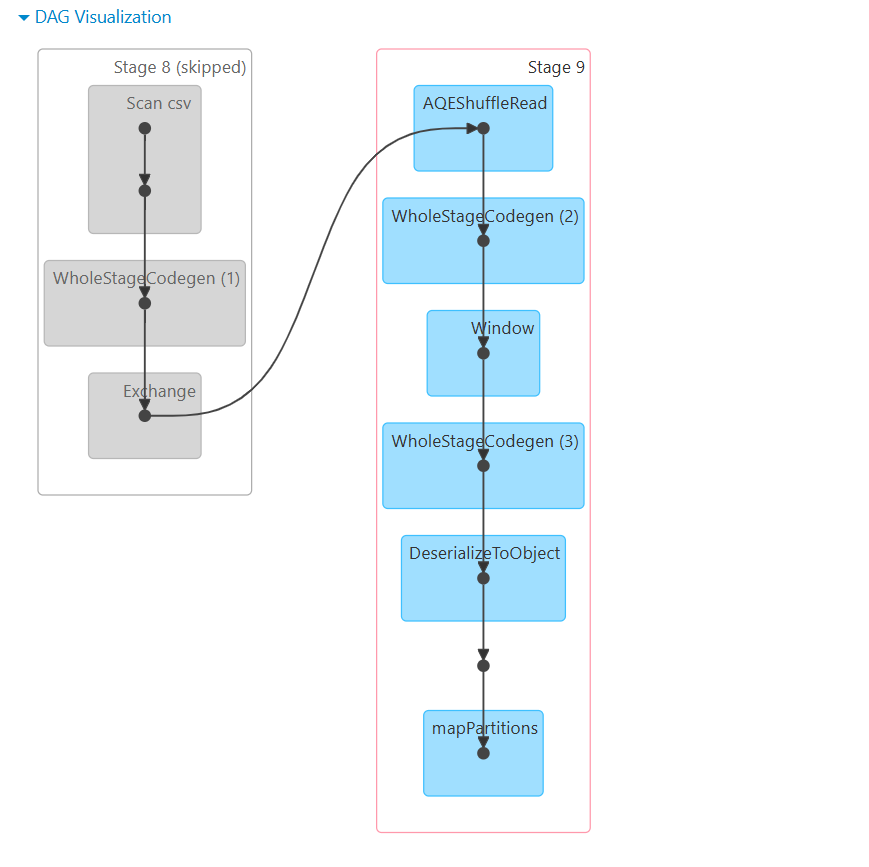

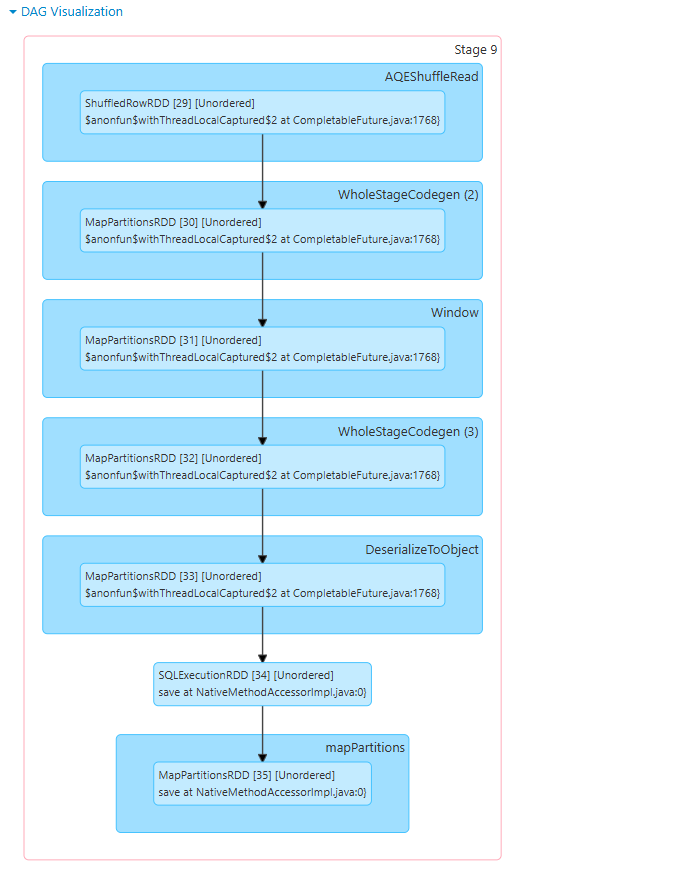

In [12]:
sc.stop()